# Lake drainage methods

# Set up code

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    22:23:47 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    22:23:47 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    22:23:47 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42189")
client

<Client: 'tcp://127.0.0.1:42189' processes=4 threads=16, memory=125.81 GiB>

# Define helper functions
This is to streamline the code

In [4]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

def strain_metrics(ds, win_cor, step, lag):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    return np.count_nonzero(abs(co)>0.95)/np.count_nonzero(co), np.mean(abs(co)), np.mean(r2).values

def optimal_window_and_leapfrog(ds):
    max_score = 0
    windows = np.arange(20,90,10)
    lags = np.round(np.logspace(0,3,7)).astype('int')
    pct_mat = np.zeros((len(windows),len(lags)))
    r2_mat = np.zeros((len(windows),len(lags)))
    for i in range(len(windows)):
        step = windows[i] # earlier experiments show step doesn't change results by much
        #for step in [10,20,40,80]:
        #    if step <= window:
        for j in range(len(lags)):
            pct,mean,r2 = strain_metrics(ds, windows[i], step,lags[j])
            print(f"Window {windows[i]}, lag {lags[j]} -> pct {pct:.2}, r2 {r2:.2}")
            pct_mat[i,j] = pct
            r2_mat[i,j]=r2
            # mean coherence not relevant I think
            temp_score = pct+r2
            if temp_score > max_score:
                max_score = temp_score
                to_return = windows[i],lags[j]
            
    fig, axs = plt.subplots(ncols=2,figsize=(15,5))
    plt0 = axs[0].pcolormesh(100*pct_mat)
    plt.colorbar(plt0,ax=axs[0],label='percentage of data with high coherence (>0.95)')
    axs[0].set_xticks(np.arange(pct_mat.shape[1]) + 0.5, minor=False)
    axs[0].set_yticks(np.arange(pct_mat.shape[0]) + 0.5, minor=False)
    axs[0].set_xticklabels(lags)
    axs[0].set_yticklabels(windows)
    axs[0].set_ylabel('Correlation window size [points included]')
    axs[0].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[0].set_title('High coherence percentage')


    plt1 = axs[1].pcolormesh(r2_mat)
    plt.colorbar(plt1,ax=axs[1],label='Average r^2 of linear strain fits')
    axs[1].set_xticks(np.arange(r2_mat.shape[1]) + 0.5, minor=False)
    axs[1].set_yticks(np.arange(r2_mat.shape[0]) + 0.5, minor=False)
    axs[1].set_xticklabels(lags)
    axs[1].set_yticklabels(windows)
    axs[1].set_ylabel('Correlation window size [points included]')
    axs[1].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[1].set_title('Mean strain rate fit r-squared')

    return to_return

def generate_strain_fit(ds,window,lag):
    b1= ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values)
    #axs[0].set_ylim([-1e-2,1e-2])
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain fitting results')
    axs[1].plot(fit.time.values,r2.values)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('r$^2$')
    return ds_new,fit

# Summer 2022 lake drainage

## A11

In [17]:
da_101_stacked  = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=1,time=range(3800,5500)),2,3e8,4e8)


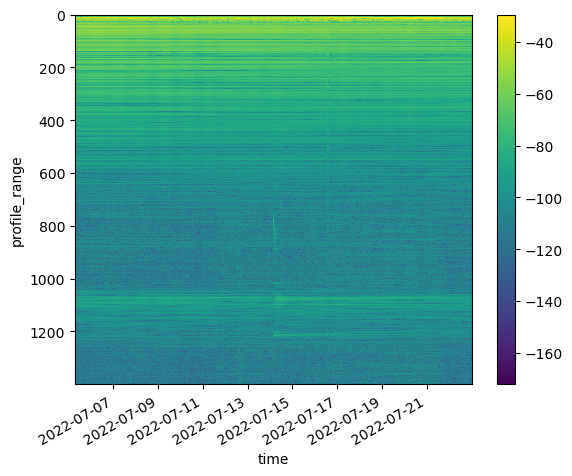

In [18]:
xa.dB(da_101_stacked).plot(x='time')
plt.gca().invert_yaxis()


Window 20, lag 1 -> pct 0.55, r2 0.69
Window 20, lag 3 -> pct 0.53, r2 0.67
Window 20, lag 10 -> pct 0.5, r2 0.71
Window 20, lag 32 -> pct 0.43, r2 0.79
Window 20, lag 100 -> pct 0.36, r2 0.82
Window 20, lag 316 -> pct 0.18, r2 0.61
Window 20, lag 1000 -> pct 0.02, r2 0.57
Window 30, lag 1 -> pct 0.55, r2 0.62
Window 30, lag 3 -> pct 0.53, r2 0.62
Window 30, lag 10 -> pct 0.49, r2 0.7
Window 30, lag 32 -> pct 0.43, r2 0.82
Window 30, lag 100 -> pct 0.36, r2 0.84
Window 30, lag 316 -> pct 0.15, r2 0.8
Window 30, lag 1000 -> pct 0.0025, r2 nan
Window 40, lag 1 -> pct 0.54, r2 0.56
Window 40, lag 3 -> pct 0.52, r2 0.59
Window 40, lag 10 -> pct 0.48, r2 0.72
Window 40, lag 32 -> pct 0.41, r2 0.85
Window 40, lag 100 -> pct 0.34, r2 0.89
Window 40, lag 316 -> pct 0.14, r2 0.85
Window 40, lag 1000 -> pct 0.00038, r2 nan
Window 50, lag 1 -> pct 0.54, r2 0.58
Window 50, lag 3 -> pct 0.52, r2 0.62
Window 50, lag 10 -> pct 0.48, r2 0.76
Window 50, lag 32 -> pct 0.41, r2 0.89
Window 50, lag 100 ->

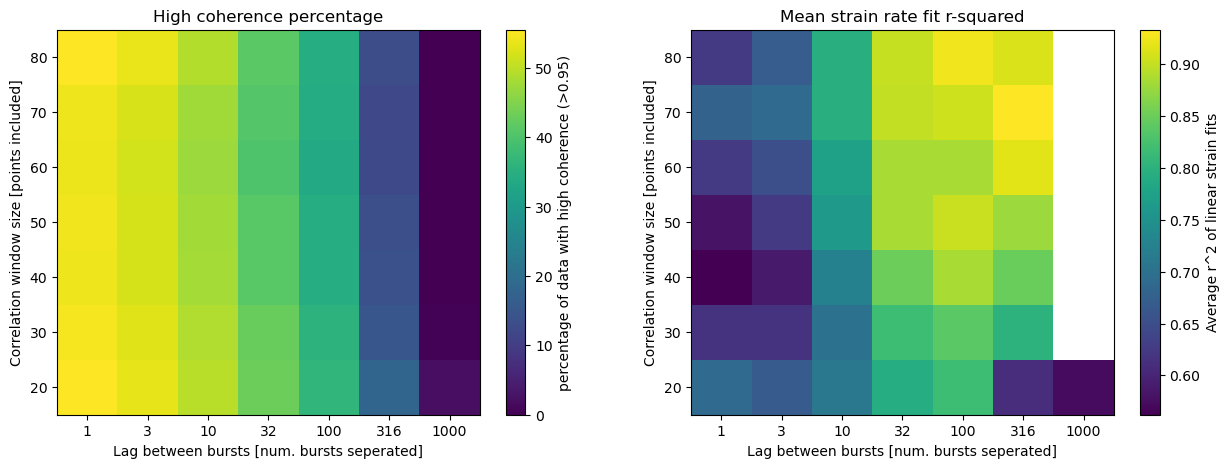

In [19]:
best_window,best_lag = optimal_window_and_leapfrog(da_101_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

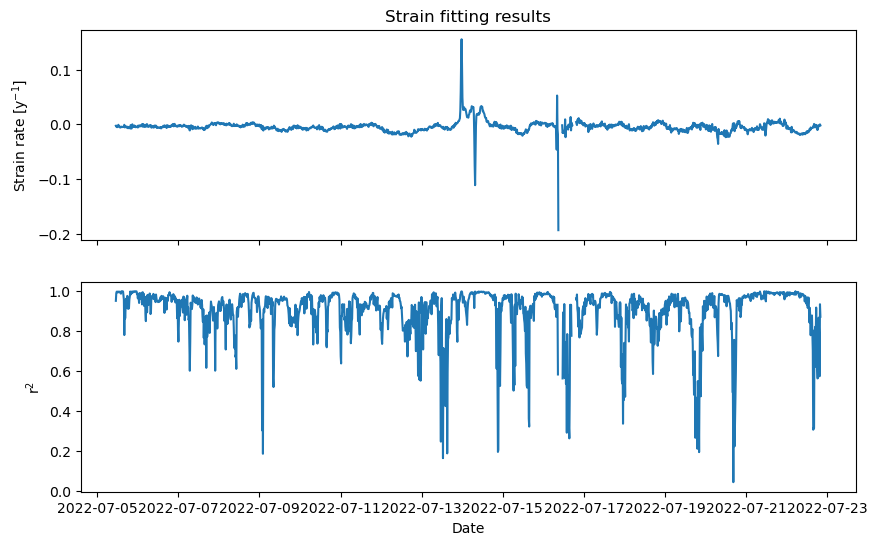

In [20]:
best_window = 80
best_lag = 32
ds_new, fit = generate_strain_fit(da_101_stacked,best_window,best_lag)

In [21]:
ds_new['doy_decimal'] = ds_new.time.dt.dayofyear + (ds_new.time.dt.hour / 24) + (ds_new.time.dt.minute / 1440) + (ds_new.time.dt.second / 86400)
fit['doy_decimal'] = fit.time.dt.dayofyear + (fit.time.dt.hour / 24) + (fit.time.dt.minute / 1440) + (fit.time.dt.second / 86400)
da_101_stacked['doy_decimal'] = da_101_stacked.time.dt.dayofyear + (da_101_stacked.time.dt.hour / 24) + (da_101_stacked.time.dt.minute / 1440) + (da_101_stacked.time.dt.second / 86400)


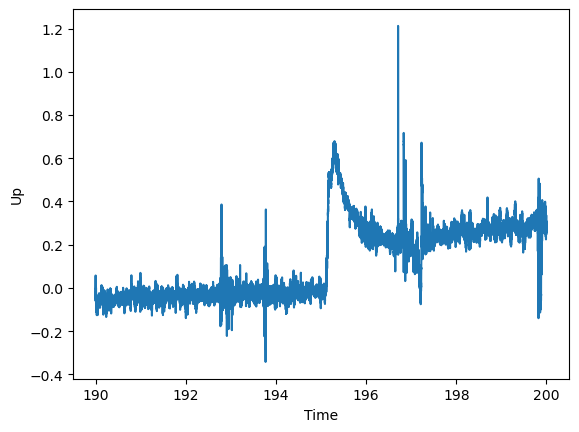

In [22]:
colnames = ['Time','East','North','Up','sigma_east','sigma_north','sigma_up']
data = pd.read_csv('sq11_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.to_xarray()
data.Up.plot(x='Time')

Text(0, 0.5, 'range [m]')

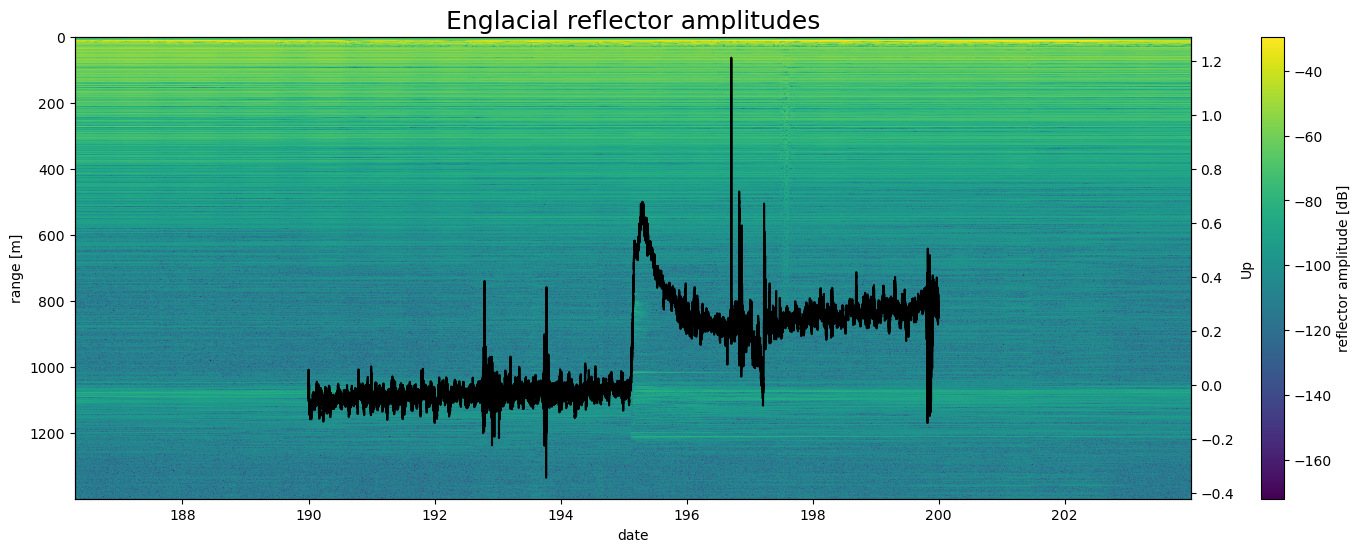

In [23]:
fig, ax = plt.subplots(figsize=(18,6))
xa.dB(da_101_stacked).plot(ax=ax,x='doy_decimal',cbar_kwargs={'label':'reflector amplitude [dB]'})
ax.invert_yaxis()
ax.set_title("Englacial reflector amplitudes",fontsize=18)
ax2 = ax.twinx()
data.Up.plot(ax=ax2,x='Time',color='k')
ax.set_xlabel('date')
ax.set_ylabel('range [m]')
      

(193.0, 197.0)

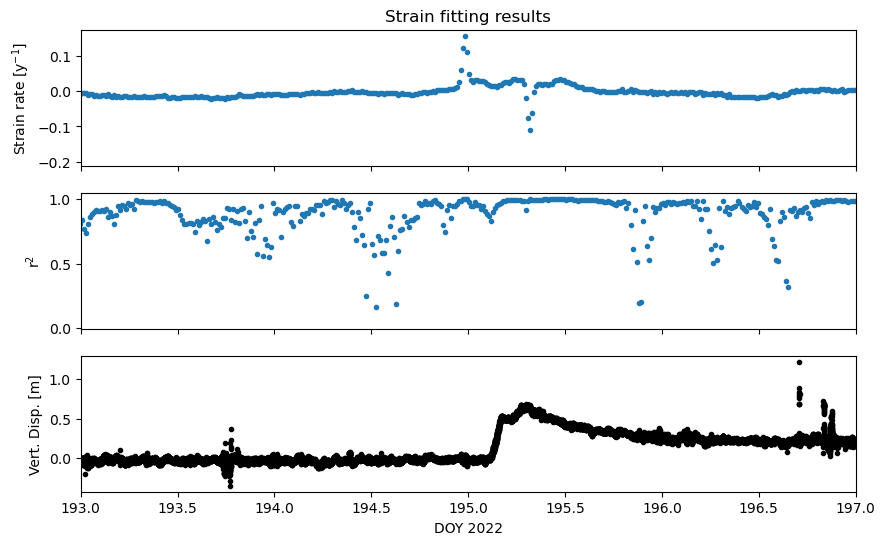

In [24]:
fig, axs = plt.subplots(nrows=3,figsize=(10,6),sharex=True)
axs[0].plot(fit.doy_decimal.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.')
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
vv = ds_new.range_diff / ds_new.time_diff * 31536000
vv_err = ds_new.err / ds_new.time_diff * 31536000
r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
axs[1].plot(fit.doy_decimal.values,r2.values,linestyle='None',marker='.')
axs[1].set_ylabel('r$^2$')
data.Up.plot(ax=axs[2],x='Time',color='k',linestyle='None',marker='.')
axs[2].set_xlabel('DOY 2022')
axs[2].set_ylabel('Vert. Disp. [m]')
axs[2].set_xlim([193,197])

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

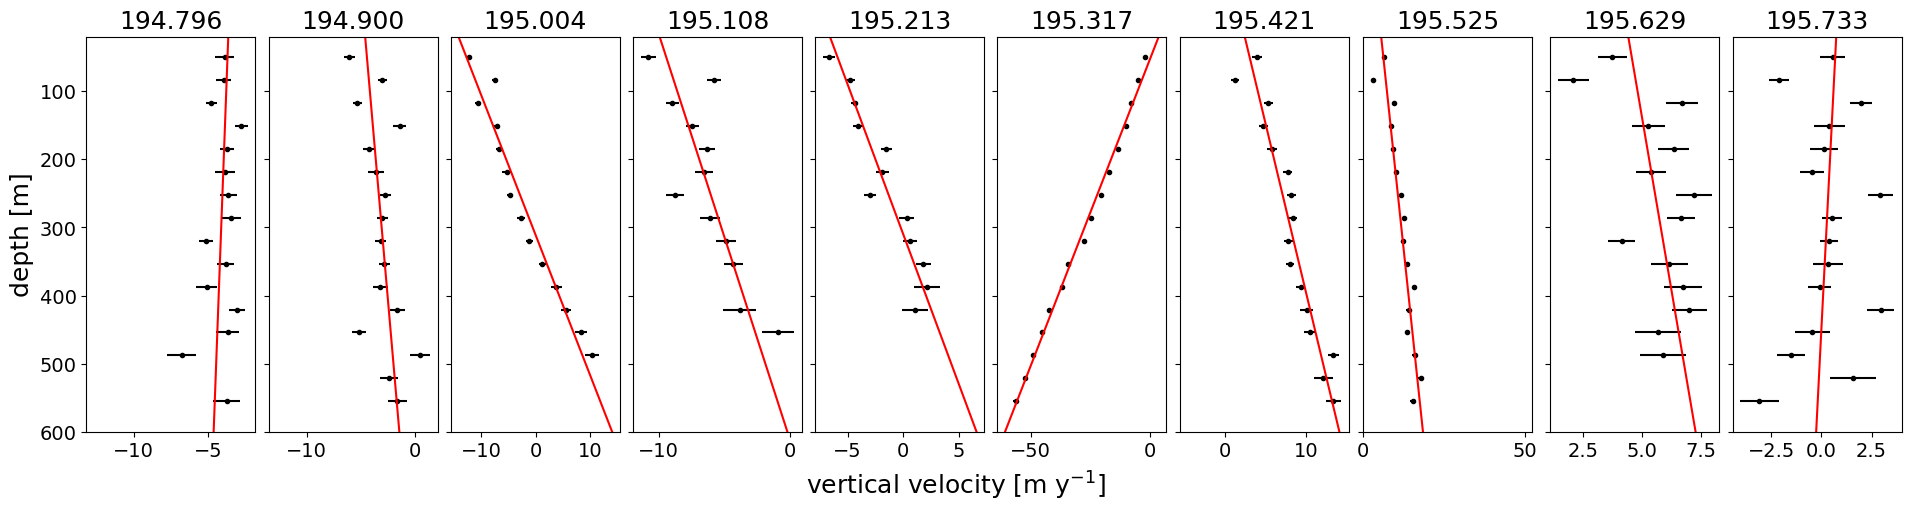

In [37]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
vv['doy_decimal'] = vv.time.dt.dayofyear + ((vv.time.dt.hour) / 24) + (vv.time.dt.minute / 1440) + (vv.time.dt.second / 86400)

plt_count = 0
for i in np.arange(800,900,10):
    axs_1[plt_count].errorbar(vv.isel(time = i) ,vv.profile_range,yerr=None,xerr=vv_err.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    slope = fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(slope,np.linspace(20,600),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(vv.doy_decimal.isel(time = i).values)[0:7]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-50,10])
    axs_1[plt_count].set_ylim([20,600])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

## Check A13

In [5]:
da_103_stacked  = custom_stacked_profile_series(ds_103.chirp.isel(attenuator_setting_pair=1,time=range(3800,5500)),2,3e8,4e8)
da_103_stacked['doy_decimal'] = da_103_stacked.time.dt.dayofyear + (da_103_stacked.time.dt.hour / 24) + (da_103_stacked.time.dt.minute / 1440) + (da_103_stacked.time.dt.second / 86400)


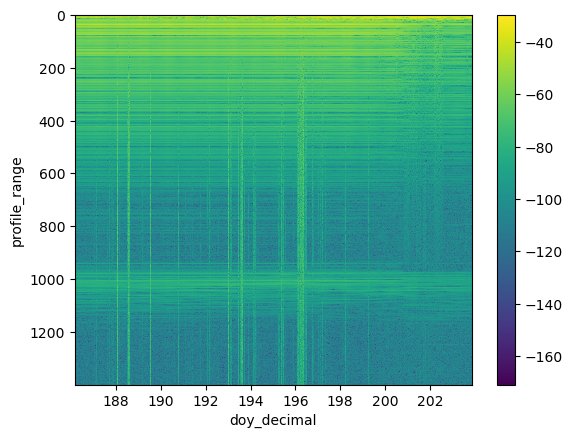

In [6]:
xa.dB(da_103_stacked).plot(x='doy_decimal')
plt.gca().invert_yaxis()


Window 20, lag 1 -> pct 0.48, r2 0.65
Window 20, lag 3 -> pct 0.46, r2 0.65
Window 20, lag 10 -> pct 0.43, r2 0.73
Window 20, lag 32 -> pct 0.39, r2 0.8
Window 20, lag 100 -> pct 0.34, r2 0.78
Window 20, lag 316 -> pct 0.28, r2 0.87
Window 20, lag 1000 -> pct 0.14, r2 0.76
Window 30, lag 1 -> pct 0.48, r2 0.65
Window 30, lag 3 -> pct 0.46, r2 0.67
Window 30, lag 10 -> pct 0.43, r2 0.76
Window 30, lag 32 -> pct 0.38, r2 0.83
Window 30, lag 100 -> pct 0.33, r2 0.83
Window 30, lag 316 -> pct 0.28, r2 0.92
Window 30, lag 1000 -> pct 0.14, r2 0.78
Window 40, lag 1 -> pct 0.48, r2 0.66
Window 40, lag 3 -> pct 0.45, r2 0.69
Window 40, lag 10 -> pct 0.42, r2 0.79
Window 40, lag 32 -> pct 0.37, r2 0.85
Window 40, lag 100 -> pct 0.32, r2 0.86
Window 40, lag 316 -> pct 0.27, r2 0.94
Window 40, lag 1000 -> pct 0.12, r2 0.75
Window 50, lag 1 -> pct 0.48, r2 0.68
Window 50, lag 3 -> pct 0.45, r2 0.72
Window 50, lag 10 -> pct 0.42, r2 0.81
Window 50, lag 32 -> pct 0.37, r2 0.87
Window 50, lag 100 -> 

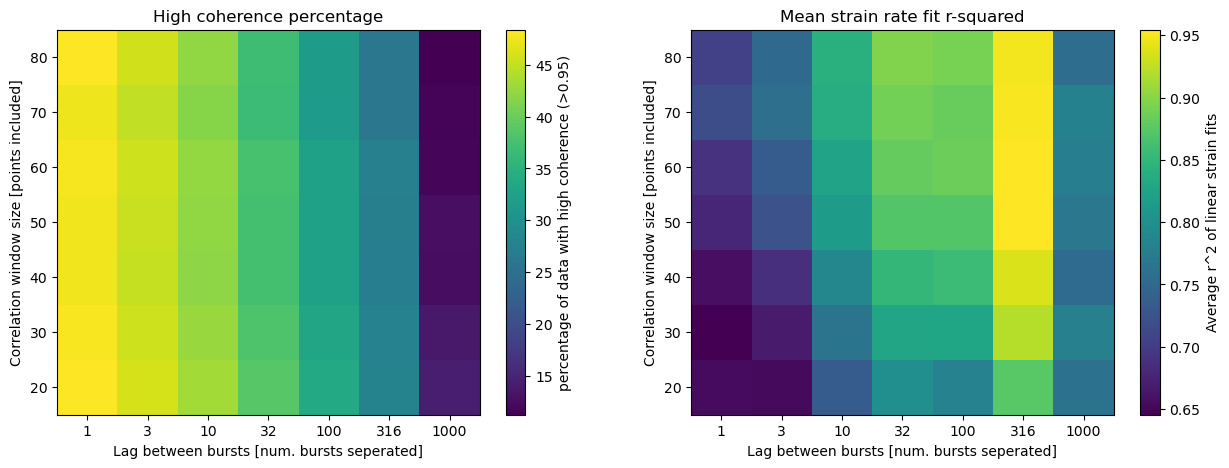

In [7]:
best_window,best_lag = optimal_window_and_leapfrog(da_103_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

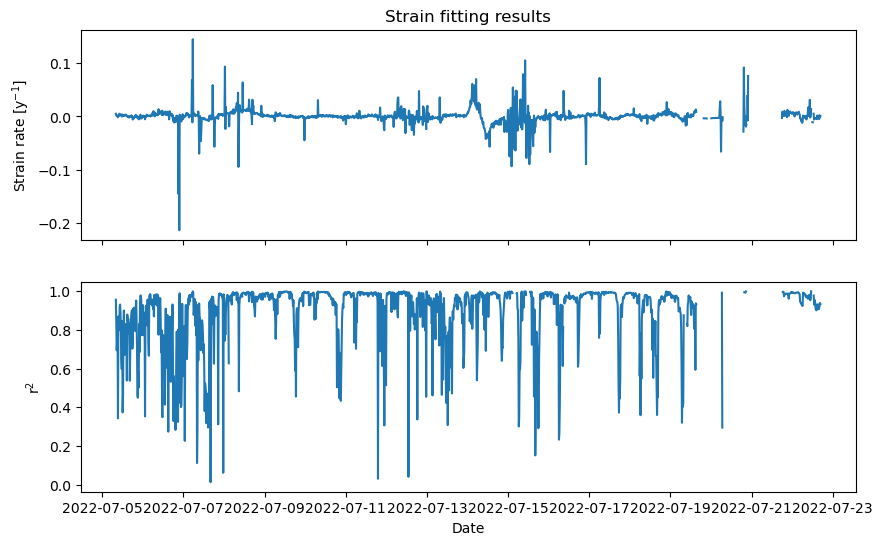

In [8]:
best_window = 80
best_lag = 32
ds_new, fit = generate_strain_fit(da_103_stacked,best_window,best_lag)

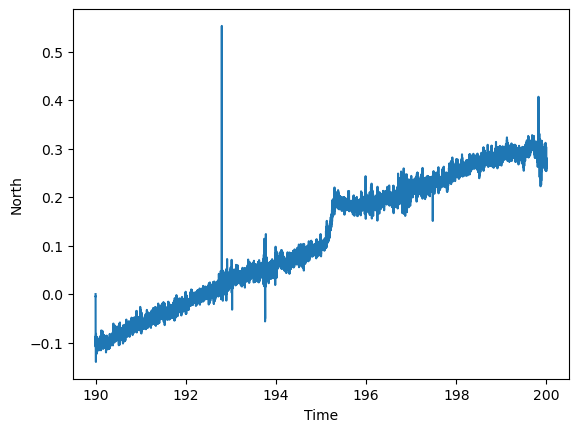

In [9]:
colnames = ['Time','East','North','Up','sigma_east','sigma_north','sigma_up']
data = pd.read_csv('sq13_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.to_xarray()
data.North.plot(x='Time')

(193.0, 197.0)

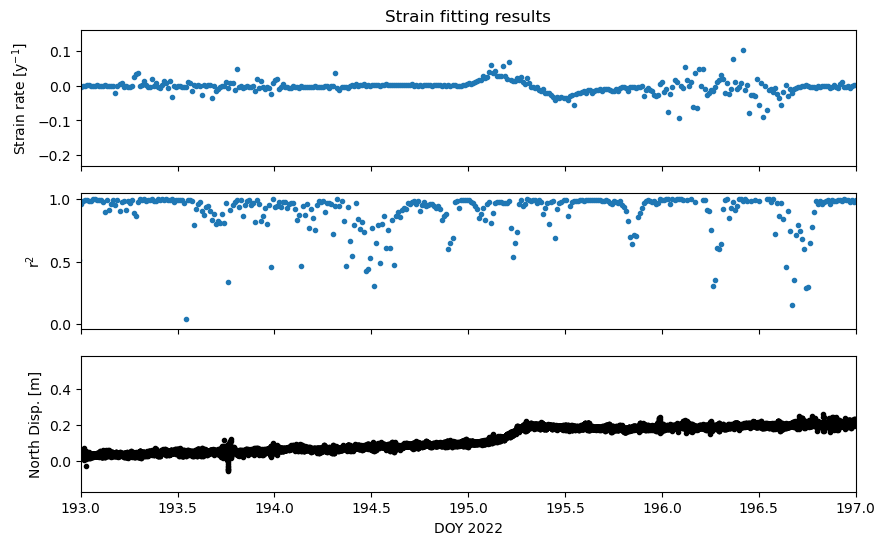

In [10]:
ds_new['doy_decimal'] = ds_new.time.dt.dayofyear + (ds_new.time.dt.hour / 24) + (ds_new.time.dt.minute / 1440) + (ds_new.time.dt.second / 86400)
fit['doy_decimal'] = fit.time.dt.dayofyear + (fit.time.dt.hour / 24) + (fit.time.dt.minute / 1440) + (fit.time.dt.second / 86400)

fig, axs = plt.subplots(nrows=3,figsize=(10,6),sharex=True)
axs[0].plot(fit.doy_decimal.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.')
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
vv = ds_new.range_diff / ds_new.time_diff * 31536000
vv_err = ds_new.err / ds_new.time_diff * 31536000
r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
axs[1].plot(fit.doy_decimal.values,r2.values,linestyle='None',marker='.')
axs[1].set_ylabel('r$^2$')
data.North.plot(ax=axs[2],x='Time',color='k',linestyle='None',marker='.')
axs[2].set_xlabel('DOY 2022')
axs[2].set_ylabel('North Disp. [m]')
axs[2].set_xlim([193,197])

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

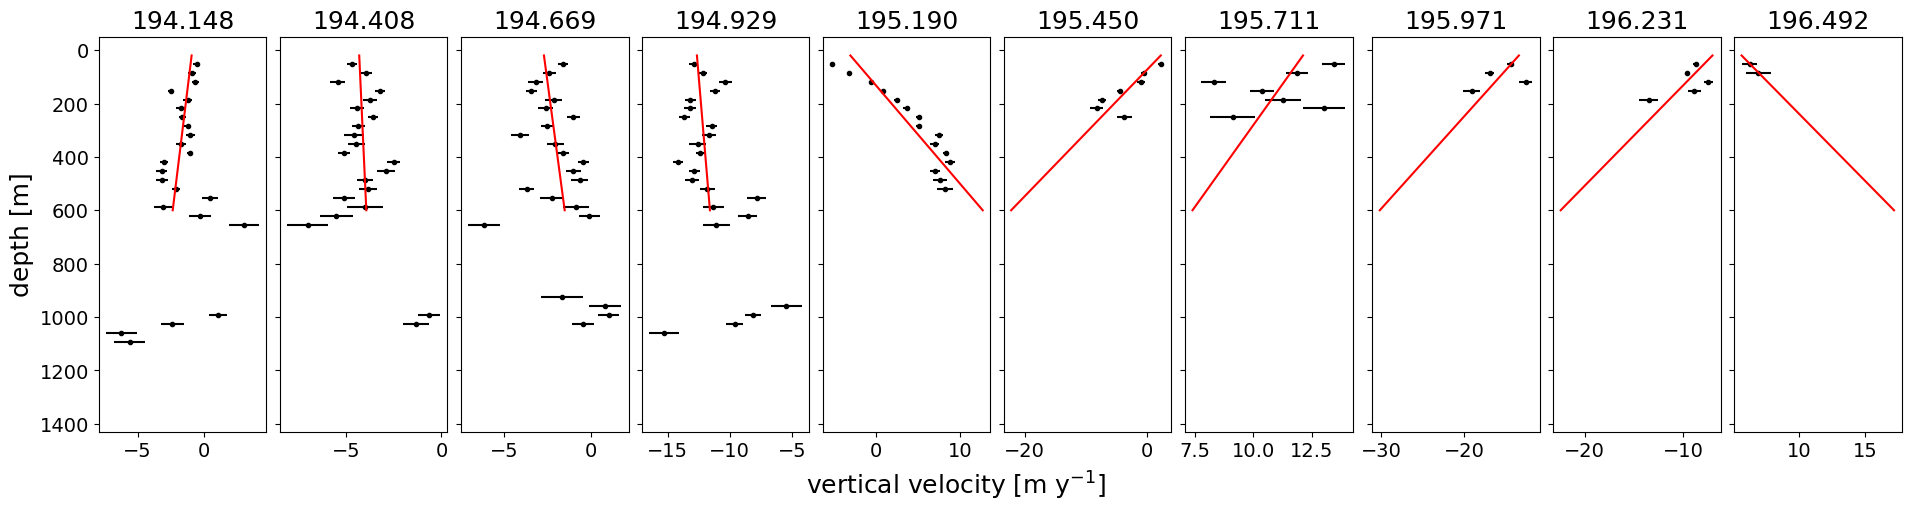

In [28]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
vv['doy_decimal'] = vv.time.dt.dayofyear + ((vv.time.dt.hour) / 24) + (vv.time.dt.minute / 1440) + (vv.time.dt.second / 86400)

plt_count = 0
for i in np.arange(750,1000,25):
    axs_1[plt_count].errorbar(vv.isel(time = i) ,vv.profile_range,yerr=None,xerr=vv_err.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    slope = fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(slope,np.linspace(20,600),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-0.2,300, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(vv.doy_decimal.isel(time = i).values)[0:7]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-3,2])
    #axs_1[plt_count].set_ylim([20,500])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

## Check A14

In [11]:
da_104_stacked = ds_104.profile_stacked.isel(attenuator_setting_pair=0,time=range(3800,5500)).compute()
da_104_stacked['doy_decimal'] = da_104_stacked.time.dt.dayofyear + (da_104_stacked.time.dt.hour / 24) + (da_104_stacked.time.dt.minute / 1440) + (da_104_stacked.time.dt.second / 86400)


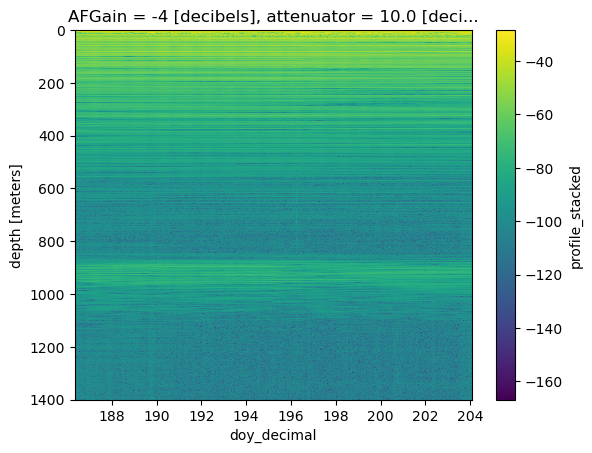

In [12]:
xa.dB(da_104_stacked).plot(x='doy_decimal')
plt.gca().invert_yaxis()


Window 20, lag 1 -> pct 0.56, r2 0.61
Window 20, lag 3 -> pct 0.55, r2 0.62
Window 20, lag 10 -> pct 0.53, r2 0.74
Window 20, lag 32 -> pct 0.49, r2 0.86
Window 20, lag 100 -> pct 0.42, r2 0.88
Window 20, lag 316 -> pct 0.24, r2 0.64
Window 20, lag 1000 -> pct 0.021, r2 0.61
Window 30, lag 1 -> pct 0.55, r2 0.57
Window 30, lag 3 -> pct 0.54, r2 0.61
Window 30, lag 10 -> pct 0.52, r2 0.76
Window 30, lag 32 -> pct 0.48, r2 0.88
Window 30, lag 100 -> pct 0.4, r2 0.87
Window 30, lag 316 -> pct 0.22, r2 0.57
Window 30, lag 1000 -> pct 0.014, r2 0.69
Window 40, lag 1 -> pct 0.55, r2 0.55
Window 40, lag 3 -> pct 0.54, r2 0.61
Window 40, lag 10 -> pct 0.52, r2 0.79
Window 40, lag 32 -> pct 0.47, r2 0.91
Window 40, lag 100 -> pct 0.4, r2 0.89
Window 40, lag 316 -> pct 0.21, r2 0.85
Window 40, lag 1000 -> pct 0.0069, r2 0.87
Window 50, lag 1 -> pct 0.54, r2 0.52
Window 50, lag 3 -> pct 0.53, r2 0.61
Window 50, lag 10 -> pct 0.51, r2 0.8
Window 50, lag 32 -> pct 0.46, r2 0.93
Window 50, lag 100 -

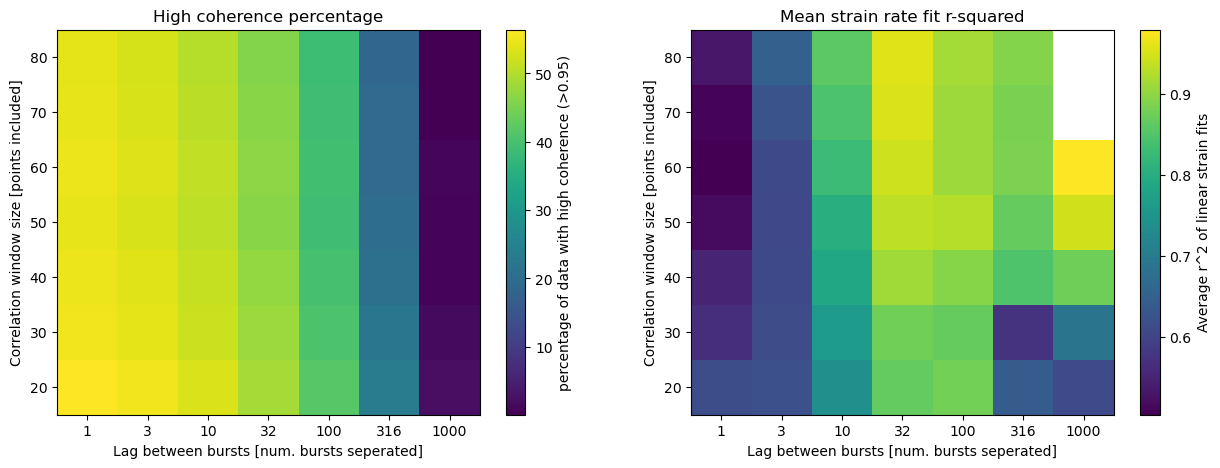

In [13]:
best_window,best_lag = optimal_window_and_leapfrog(da_104_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

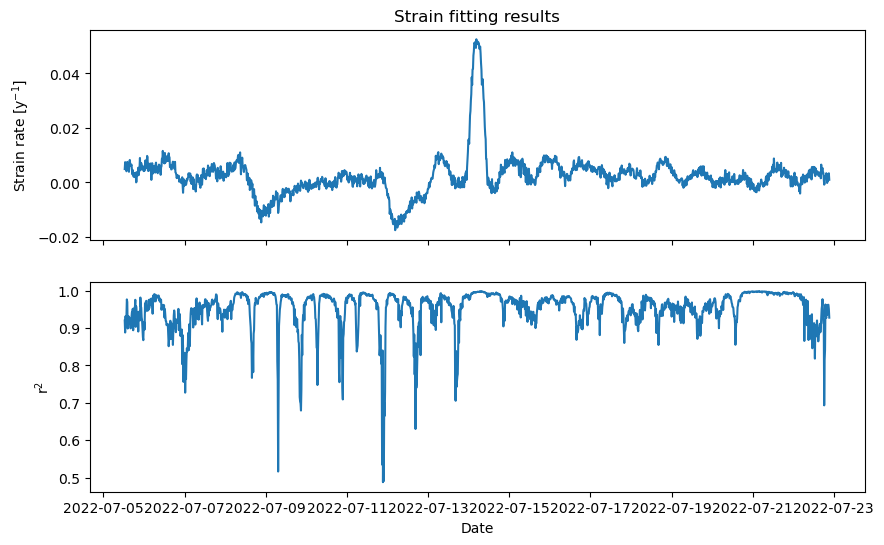

In [14]:
best_window = 70
best_lag = 32
ds_new, fit = generate_strain_fit(da_104_stacked,best_window,best_lag)

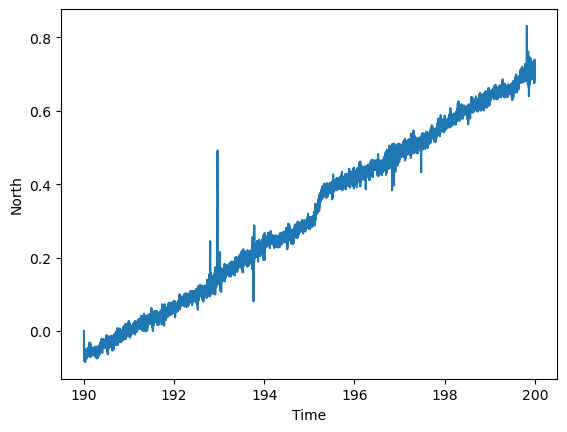

In [15]:
colnames = ['Time','East','North','Up','sigma_east','sigma_north','sigma_up']
data = pd.read_csv('sq14_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.to_xarray()
data.North.plot(x='Time')

(193.0, 197.0)

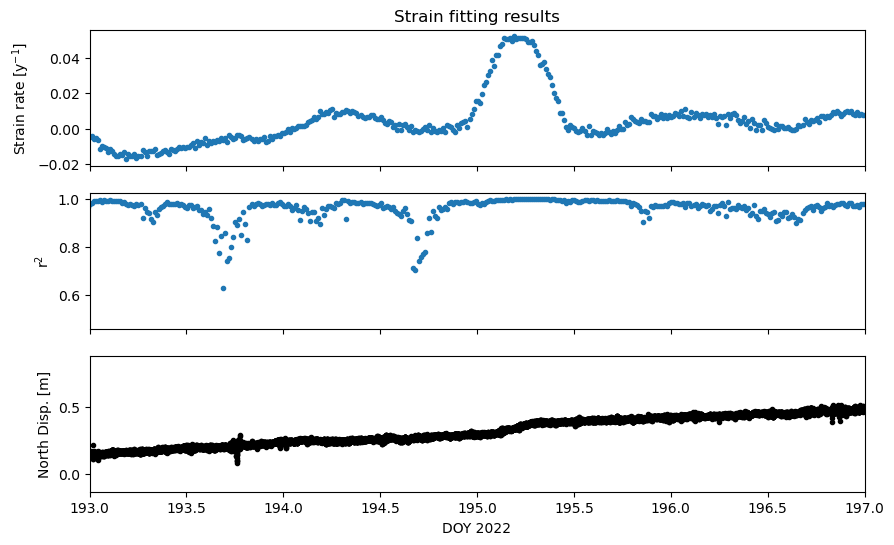

In [16]:
ds_new['doy_decimal'] = ds_new.time.dt.dayofyear + (ds_new.time.dt.hour / 24) + (ds_new.time.dt.minute / 1440) + (ds_new.time.dt.second / 86400)
fit['doy_decimal'] = fit.time.dt.dayofyear + (fit.time.dt.hour / 24) + (fit.time.dt.minute / 1440) + (fit.time.dt.second / 86400)

fig, axs = plt.subplots(nrows=3,figsize=(10,6),sharex=True)
axs[0].plot(fit.doy_decimal.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.')
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
vv = ds_new.range_diff / ds_new.time_diff * 31536000
vv_err = ds_new.err / ds_new.time_diff * 31536000
r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
axs[1].plot(fit.doy_decimal.values,r2.values,linestyle='None',marker='.')
axs[1].set_ylabel('r$^2$')
data.North.plot(ax=axs[2],x='Time',color='k',linestyle='None',marker='.')
axs[2].set_xlabel('DOY 2022')
axs[2].set_ylabel('North Disp. [m]')
axs[2].set_xlim([193,197])

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

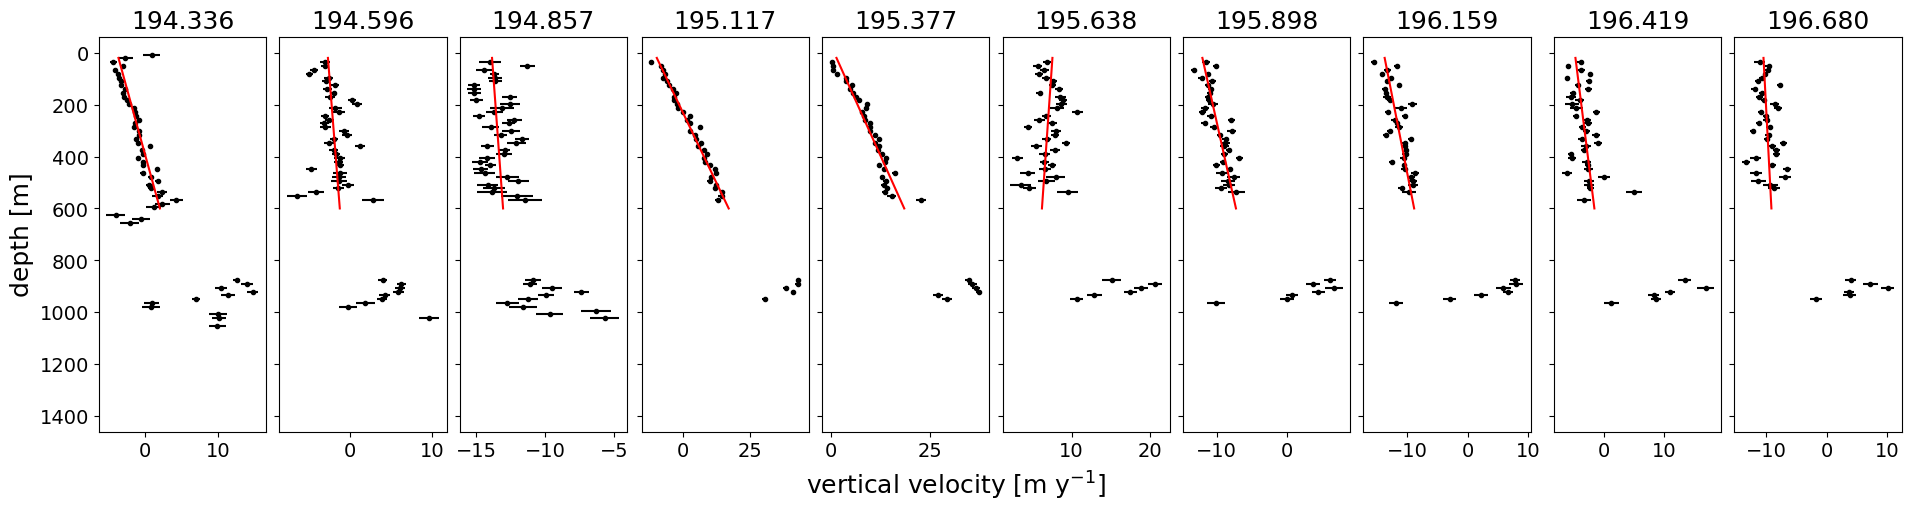

In [40]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
vv['doy_decimal'] = vv.time.dt.dayofyear + ((vv.time.dt.hour) / 24) + (vv.time.dt.minute / 1440) + (vv.time.dt.second / 86400)

plt_count = 0
for i in np.arange(750,1000,25):
    axs_1[plt_count].errorbar(vv.isel(time = i) ,vv.profile_range,yerr=None,xerr=vv_err.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    slope = fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(slope,np.linspace(20,600),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-0.2,300, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(vv.doy_decimal.isel(time = i).values)[0:7]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-3,2])
    #axs_1[plt_count].set_ylim([20,500])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

# Summer 2023 lake drainage
Unfortunately no A11 data. 

In [75]:
da_103_stacked  = ds_103_s.profile_stacked.isel(attenuator_setting_pair=2,time=range(20000,40000)).compute()
da_103_stacked['doy_decimal'] = da_103_stacked.time.dt.dayofyear + (da_103_stacked.time.dt.hour / 24) + (da_103_stacked.time.dt.minute / 1440) + (da_103_stacked.time.dt.second / 86400)


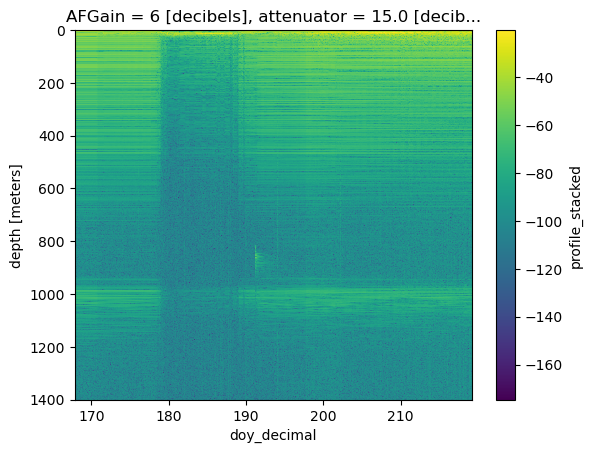

In [78]:
xa.dB(da_103_stacked).plot(x='doy_decimal')
plt.gca().invert_yaxis()


Window 20, lag 1 -> pct 0.47, r2 0.53
Window 20, lag 3 -> pct 0.46, r2 0.54
Window 20, lag 10 -> pct 0.43, r2 0.55
Window 20, lag 32 -> pct 0.37, r2 0.6
Window 20, lag 100 -> pct 0.3, r2 0.68
Window 20, lag 316 -> pct 0.27, r2 0.8
Window 20, lag 1000 -> pct 0.17, r2 0.96
Window 30, lag 1 -> pct 0.47, r2 0.51
Window 30, lag 3 -> pct 0.46, r2 0.53
Window 30, lag 10 -> pct 0.43, r2 0.56
Window 30, lag 32 -> pct 0.37, r2 0.63
Window 30, lag 100 -> pct 0.29, r2 0.72
Window 30, lag 316 -> pct 0.26, r2 0.85
Window 30, lag 1000 -> pct 0.15, r2 0.98
Window 40, lag 1 -> pct 0.47, r2 0.51
Window 40, lag 3 -> pct 0.45, r2 0.53
Window 40, lag 10 -> pct 0.42, r2 0.57
Window 40, lag 32 -> pct 0.36, r2 0.65
Window 40, lag 100 -> pct 0.29, r2 0.74
Window 40, lag 316 -> pct 0.26, r2 0.86
Window 40, lag 1000 -> pct 0.14, r2 0.98
Window 50, lag 1 -> pct 0.46, r2 0.5
Window 50, lag 3 -> pct 0.45, r2 0.54
Window 50, lag 10 -> pct 0.42, r2 0.58
Window 50, lag 32 -> pct 0.36, r2 0.66
Window 50, lag 100 -> pct

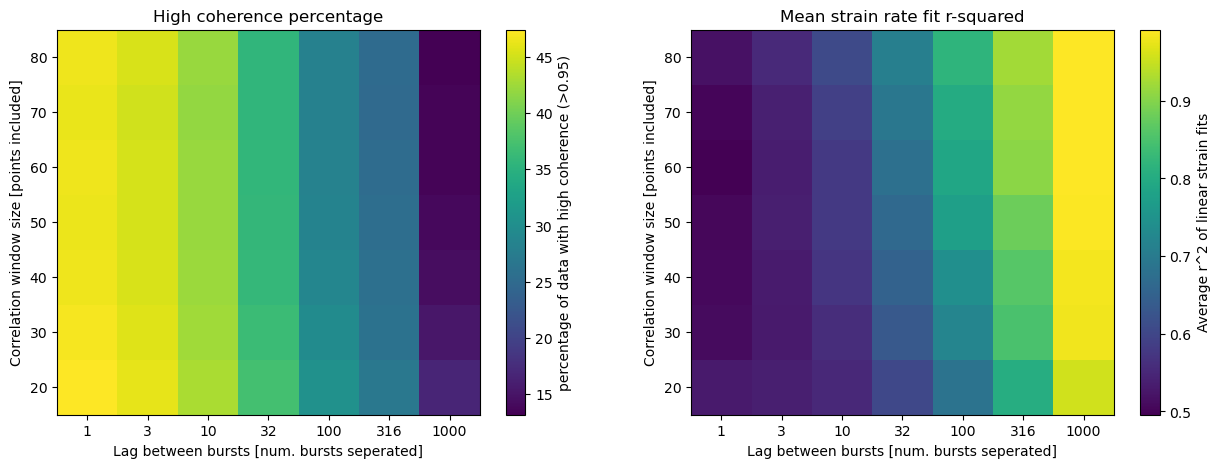

In [79]:
best_window,best_lag = optimal_window_and_leapfrog(da_103_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

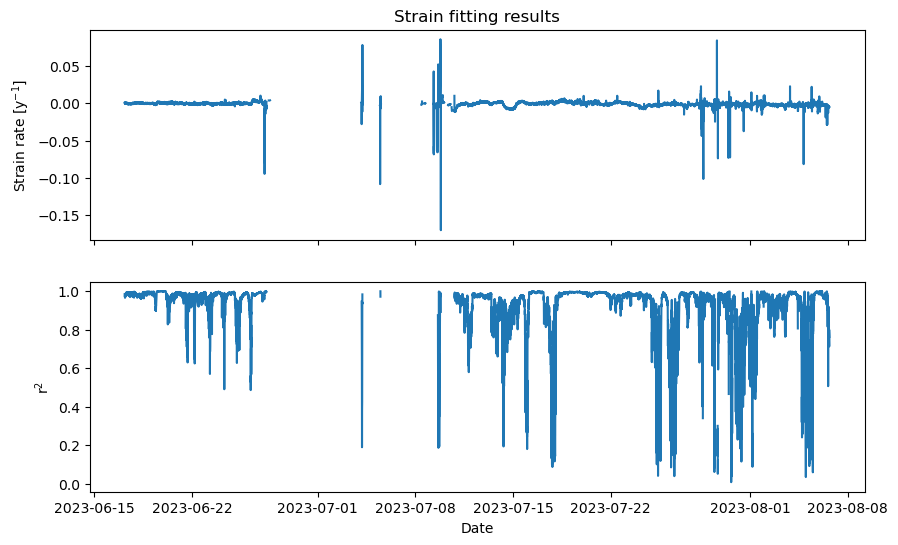

In [80]:
ds_new, fit = generate_strain_fit(da_103_stacked,best_window,best_lag)

Too noisy and not that good of data. Try focusing around drainage

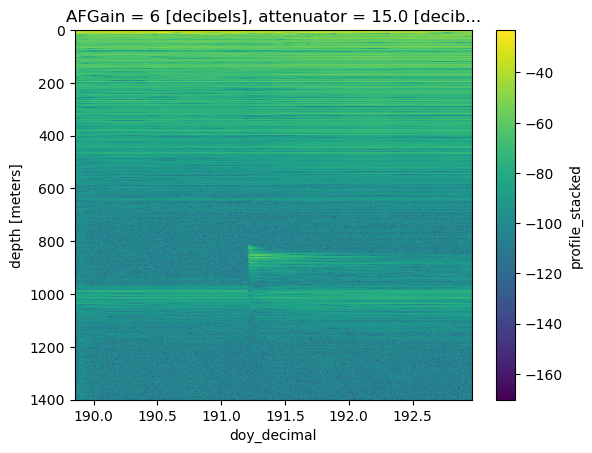

In [81]:
da_crop = da_103_stacked.isel(time=range(9700,10900))
xa.dB(da_crop).plot(x='doy_decimal')
plt.gca().invert_yaxis()


Window 20, lag 1 -> pct 0.52, r2 0.6
Window 20, lag 3 -> pct 0.52, r2 0.6
Window 20, lag 10 -> pct 0.5, r2 0.57
Window 20, lag 32 -> pct 0.44, r2 0.54
Window 20, lag 100 -> pct 0.3, r2 0.57
Window 20, lag 316 -> pct 0.15, r2 0.66
Window 20, lag 1000 -> pct 0.018, r2 0.61
Window 30, lag 1 -> pct 0.51, r2 0.57
Window 30, lag 3 -> pct 0.51, r2 0.59
Window 30, lag 10 -> pct 0.49, r2 0.57
Window 30, lag 32 -> pct 0.43, r2 0.57
Window 30, lag 100 -> pct 0.29, r2 0.61
Window 30, lag 316 -> pct 0.13, r2 0.69
Window 30, lag 1000 -> pct 0.005, r2 0.66
Window 40, lag 1 -> pct 0.51, r2 0.57
Window 40, lag 3 -> pct 0.51, r2 0.57
Window 40, lag 10 -> pct 0.49, r2 0.55
Window 40, lag 32 -> pct 0.42, r2 0.57
Window 40, lag 100 -> pct 0.28, r2 0.66
Window 40, lag 316 -> pct 0.12, r2 0.67
Window 40, lag 1000 -> pct 0.0029, r2 0.65
Window 50, lag 1 -> pct 0.51, r2 0.56
Window 50, lag 3 -> pct 0.51, r2 0.57
Window 50, lag 10 -> pct 0.48, r2 0.57
Window 50, lag 32 -> pct 0.42, r2 0.61
Window 50, lag 100 ->

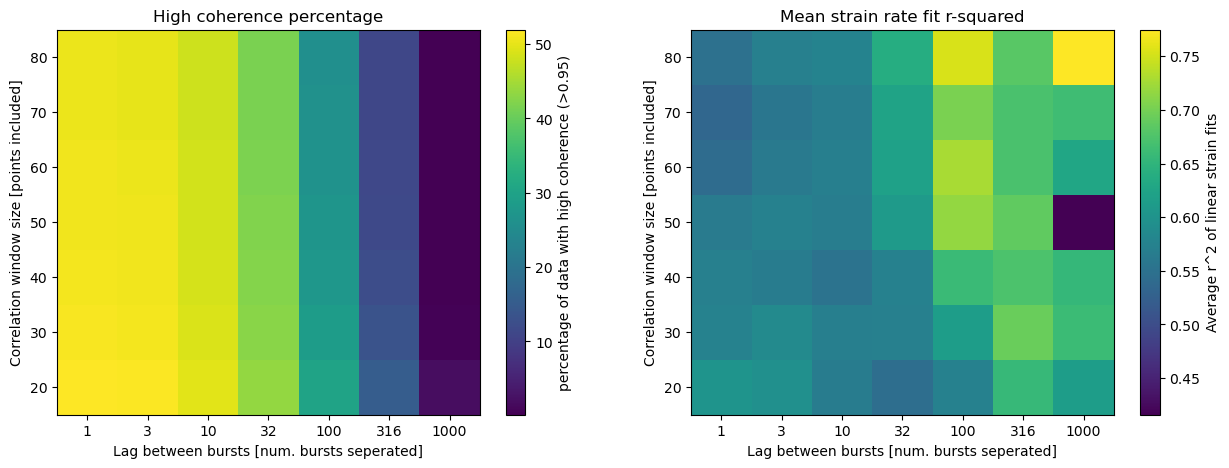

In [82]:
best_window,best_lag = optimal_window_and_leapfrog(da_crop)
print(f'Best window: {best_window}, best lag: {best_lag}')

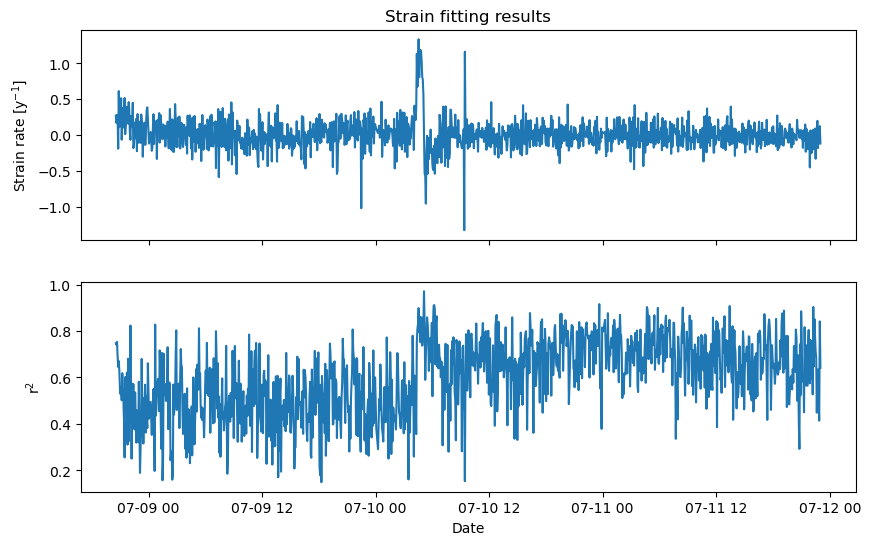

In [83]:
ds_new, fit = generate_strain_fit(da_crop,best_window,best_lag)

(190.0, 192.0)

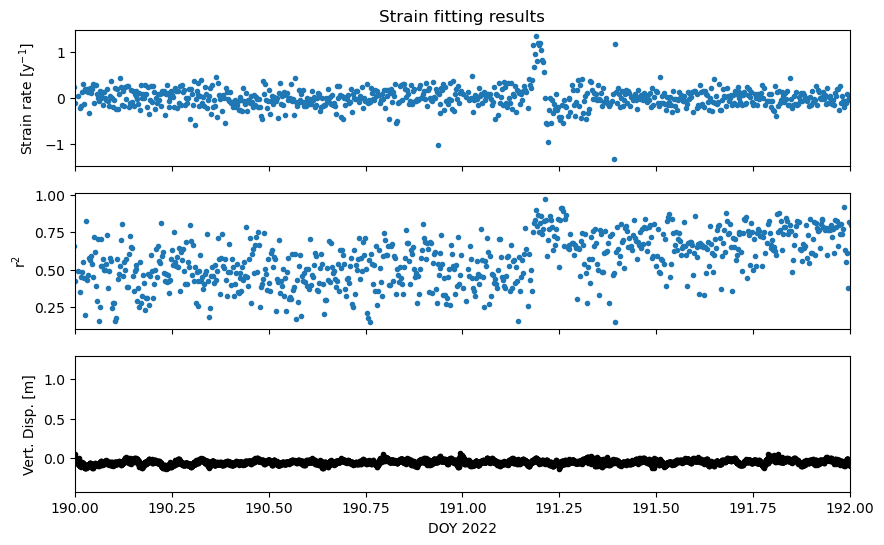

In [84]:
ds_new['doy_decimal'] = ds_new.time.dt.dayofyear + (ds_new.time.dt.hour / 24) + (ds_new.time.dt.minute / 1440) + (ds_new.time.dt.second / 86400)
fit['doy_decimal'] = fit.time.dt.dayofyear + (fit.time.dt.hour / 24) + (fit.time.dt.minute / 1440) + (fit.time.dt.second / 86400)

fig, axs = plt.subplots(nrows=3,figsize=(10,6),sharex=True)
axs[0].plot(fit.doy_decimal.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.')
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
vv = ds_new.range_diff / ds_new.time_diff * 31536000
vv_err = ds_new.err / ds_new.time_diff * 31536000
r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
axs[1].plot(fit.doy_decimal.values,r2.values,linestyle='None',marker='.')
axs[1].set_ylabel('r$^2$')
data.Up.plot(ax=axs[2],x='Time',color='k',linestyle='None',marker='.')
axs[2].set_xlabel('DOY 2022')
axs[2].set_ylabel('Vert. Disp. [m]')
axs[2].set_xlim([190,192])

R-squared values are quite low, will need to investigate fits

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

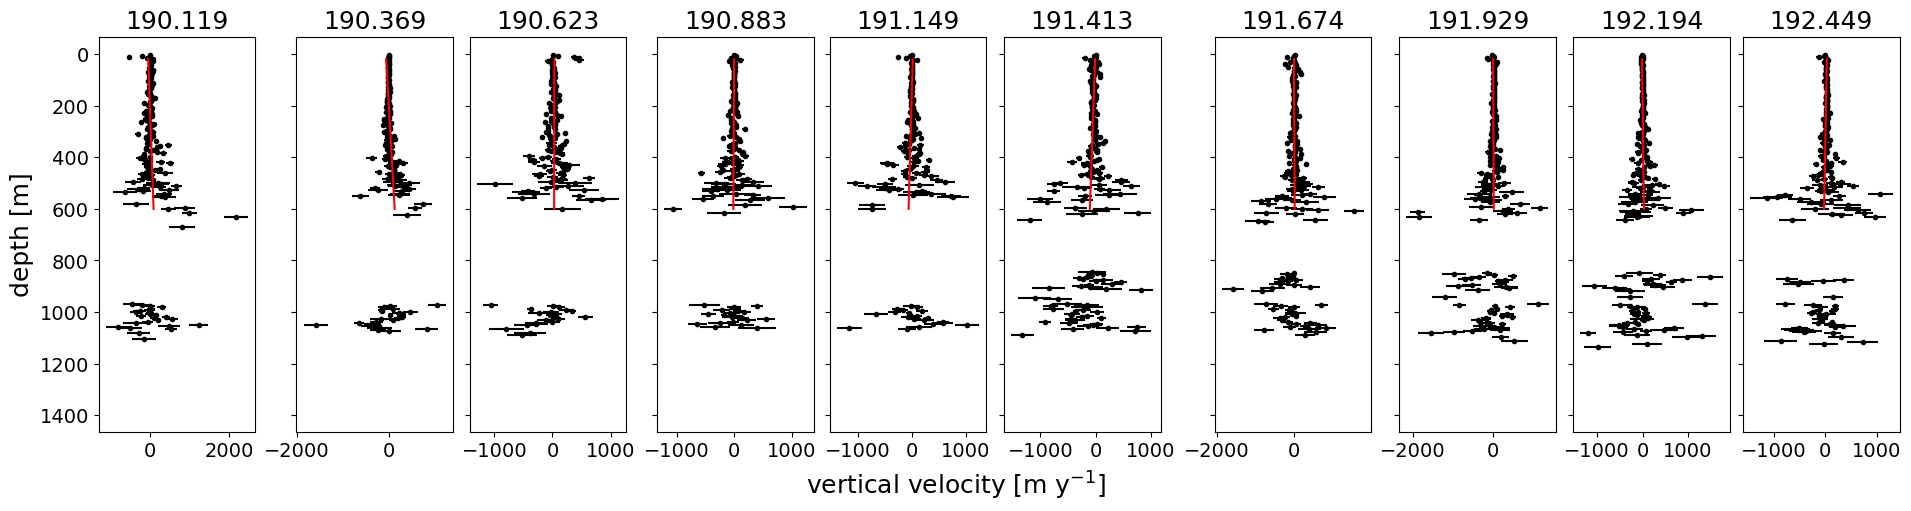

In [89]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
vv['doy_decimal'] = vv.time.dt.dayofyear + ((vv.time.dt.hour) / 24) + (vv.time.dt.minute / 1440) + (vv.time.dt.second / 86400)

plt_count = 0
for i in np.arange(100,1100,100):
    axs_1[plt_count].errorbar(vv.isel(time = i) ,vv.profile_range,yerr=None,xerr=vv_err.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    slope = fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(slope,np.linspace(20,600),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-0.2,300, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(vv.doy_decimal.isel(time = i).values)[0:7]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-3,2])
    #axs_1[plt_count].set_ylim([20,500])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

Checking A104

In [90]:
da_104_stacked  = custom_stacked_profile_series(ds_104_s.chirp.isel(attenuator_setting_pair=1,time=range(3800,5500)),2,3e8,4e8)
da_104_stacked['doy_decimal'] = da_104_stacked.time.dt.dayofyear + (da_104_stacked.time.dt.hour / 24) + (da_104_stacked.time.dt.minute / 1440) + (da_104_stacked.time.dt.second / 86400)


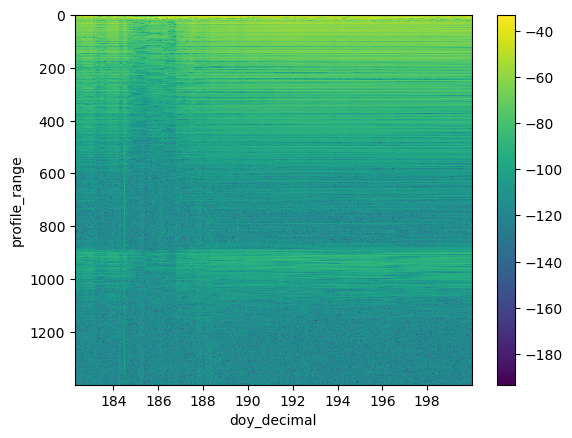

In [91]:
xa.dB(da_104_stacked).plot(x='doy_decimal')
plt.gca().invert_yaxis()


Window 20, lag 1 -> pct 0.52, r2 0.64
Window 20, lag 3 -> pct 0.49, r2 0.66
Window 20, lag 10 -> pct 0.41, r2 0.74
Window 20, lag 32 -> pct 0.34, r2 0.85
Window 20, lag 100 -> pct 0.26, r2 0.83
Window 20, lag 316 -> pct 0.14, r2 0.81
Window 20, lag 1000 -> pct 0.027, r2 0.92
Window 30, lag 1 -> pct 0.51, r2 0.59
Window 30, lag 3 -> pct 0.48, r2 0.65
Window 30, lag 10 -> pct 0.4, r2 0.76
Window 30, lag 32 -> pct 0.32, r2 0.88
Window 30, lag 100 -> pct 0.26, r2 0.88
Window 30, lag 316 -> pct 0.12, r2 0.84
Window 30, lag 1000 -> pct 0.02, r2 0.91
Window 40, lag 1 -> pct 0.5, r2 0.63
Window 40, lag 3 -> pct 0.47, r2 0.68
Window 40, lag 10 -> pct 0.39, r2 0.79
Window 40, lag 32 -> pct 0.32, r2 0.91
Window 40, lag 100 -> pct 0.25, r2 0.87
Window 40, lag 316 -> pct 0.11, r2 0.86
Window 40, lag 1000 -> pct 0.015, r2 0.91
Window 50, lag 1 -> pct 0.5, r2 0.62
Window 50, lag 3 -> pct 0.47, r2 0.67
Window 50, lag 10 -> pct 0.39, r2 0.81
Window 50, lag 32 -> pct 0.31, r2 0.92
Window 50, lag 100 -> 

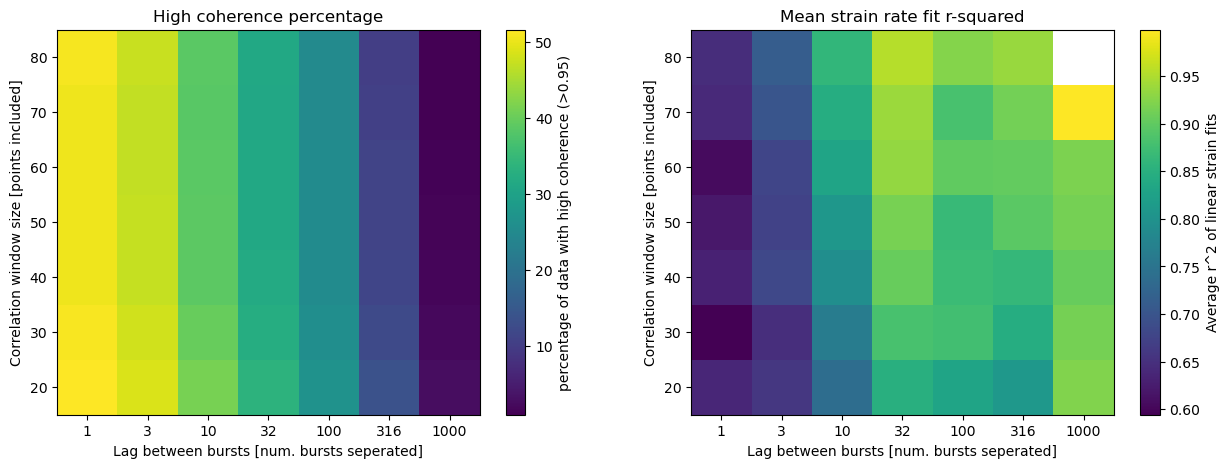

In [92]:
best_window,best_lag = optimal_window_and_leapfrog(da_104_stacked)
print(f'Best window: {best_window}, best lag: {best_lag}')

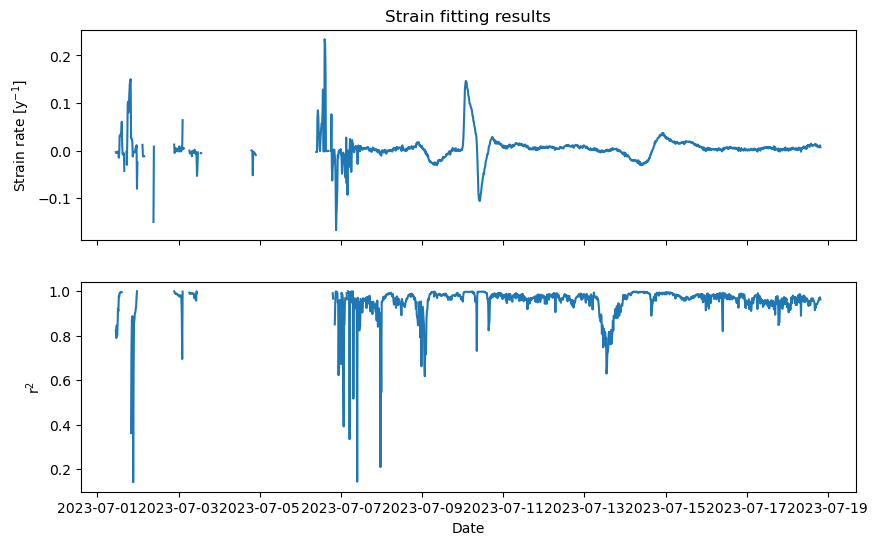

In [93]:
ds_new, fit = generate_strain_fit(da_104_stacked,best_window,best_lag)

(190.0, 192.0)

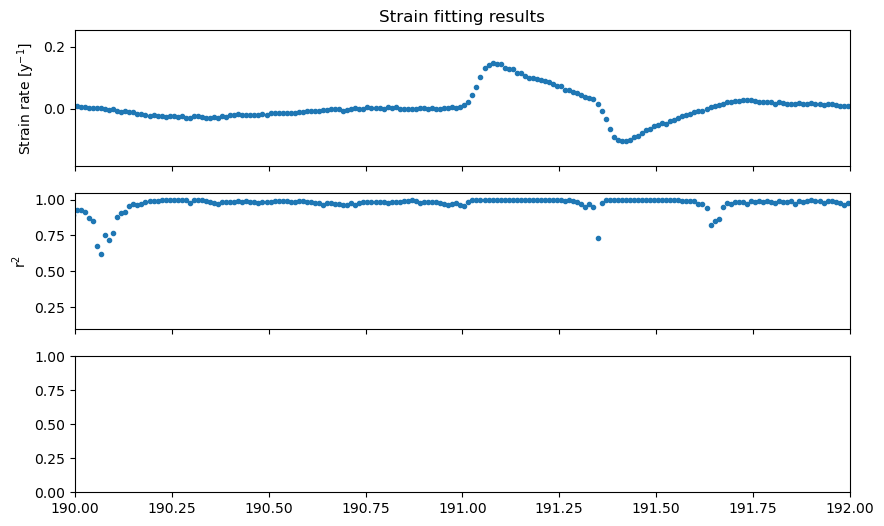

In [94]:
ds_new['doy_decimal'] = ds_new.time.dt.dayofyear + (ds_new.time.dt.hour / 24) + (ds_new.time.dt.minute / 1440) + (ds_new.time.dt.second / 86400)
fit['doy_decimal'] = fit.time.dt.dayofyear + (fit.time.dt.hour / 24) + (fit.time.dt.minute / 1440) + (fit.time.dt.second / 86400)

fig, axs = plt.subplots(nrows=3,figsize=(10,6),sharex=True)
axs[0].plot(fit.doy_decimal.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.')
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
vv = ds_new.range_diff / ds_new.time_diff * 31536000
vv_err = ds_new.err / ds_new.time_diff * 31536000
r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
axs[1].plot(fit.doy_decimal.values,r2.values,linestyle='None',marker='.')
axs[1].set_ylabel('r$^2$')
#data.Up.plot(ax=axs[2],x='Time',color='k',linestyle='None',marker='.')
#axs[2].set_xlabel('DOY 2022')
#axs[2].set_ylabel('Vert. Disp. [m]')
axs[2].set_xlim([190,192])

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

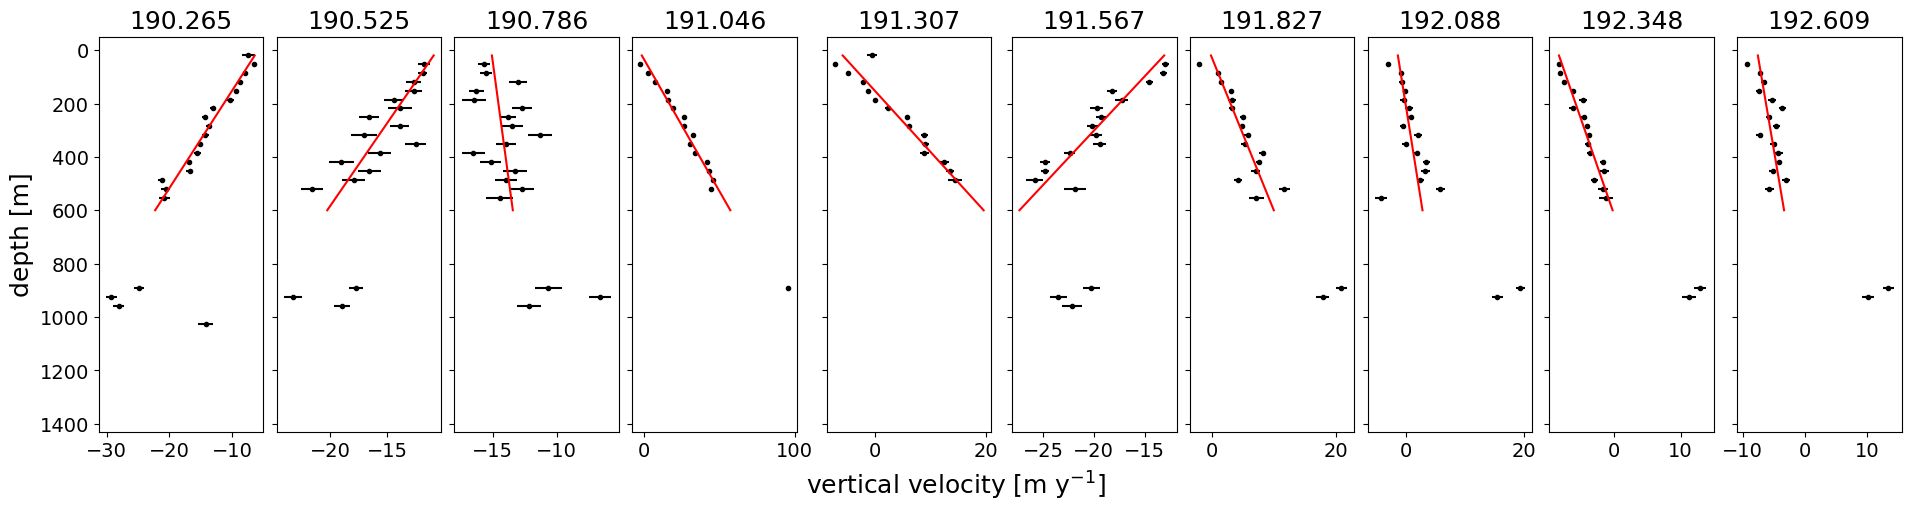

In [95]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
vv['doy_decimal'] = vv.time.dt.dayofyear + ((vv.time.dt.hour) / 24) + (vv.time.dt.minute / 1440) + (vv.time.dt.second / 86400)

plt_count = 0
for i in np.arange(750,1000,25):
    axs_1[plt_count].errorbar(vv.isel(time = i) ,vv.profile_range,yerr=None,xerr=vv_err.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    slope = fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(slope,np.linspace(20,600),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-0.2,300, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(vv.doy_decimal.isel(time = i).values)[0:7]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-3,2])
    #axs_1[plt_count].set_ylim([20,500])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)